In [55]:
%matplotlib inline
import numpy as np
import torch
import matplotlib.pyplot as plt
from tqdm import tqdm_notebook as tqdm
from scipy.stats import levy_stable
import scipy

# Langevin Monte Carlo

New samples are proposed by simulating the Langevin Stochastic Differential Equation (SDE) which is given by

$$dX_t = -\nabla U(X_t)dt + \sqrt{2}dB_t$$

where $U$ is the potential function and $B_t$ is the standard Brownian motion.

### Example
Let $U(\mathbf{z}) = \frac{1}{2}\left(\frac{\|\mathbf{z}\|-2}{0.4}\right)^2 - \log\left(e^{-0.5\left[\frac{\mathbf{z}_1 - 2}{0.6}\right]} + e^{-0.5\left[\frac{\mathbf{z}_1 + 2}{0.6}\right]}\right)$, and $p(\mathbf{z}) \propto e^{-U(\mathbf{z})}$ be the distribution we want to sample from.

Let's visualize the (unnormalized) density.

In [56]:
def npdensity1(z):
    z1, z2 = z[:, 0], z[:, 1]
    norm = np.sqrt(z1 ** 2 + z2 ** 2)
    exp1 = np.exp(-0.5 * ((z1 - 2) / 0.6) ** 2)
    exp2 = np.exp(-0.5 * ((z1 + 2) / 0.6) ** 2)
    u = 0.5 * ((norm - 2) / 0.4) ** 2 - np.log(exp1 + exp2)
    return np.exp(-u)

def npdensity2(z):
    x, y = z[:, 0], z[:, 1]
    u = 0.8 * x ** 2 + (y - ((x**2)**(1/3)))**2
    u = u / 2**2
    return np.exp(-u)

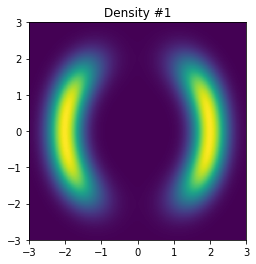

In [57]:
r = np.linspace(-5, 5, 1000)
x, y = np.meshgrid(r, r)
z = np.vstack([x.flatten(), y.flatten()]).T

q0 = npdensity1(z)
plt.pcolormesh(x, y, q0.reshape(x.shape),
                           cmap='viridis')
plt.gca().set_aspect('equal', adjustable='box')
plt.xlim([-3, 3])
plt.ylim([-3, 3])
plt.title('Density #1')
plt.show()

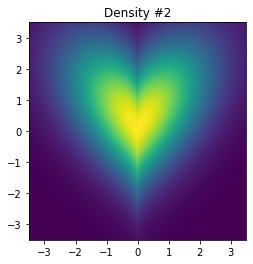

In [58]:
r = np.linspace(-5, 5, 1000)
x, y = np.meshgrid(r, r)
z = np.vstack([x.flatten(), y.flatten()]).T

q0 = npdensity2(z)
plt.pcolormesh(x, y, q0.reshape(x.shape),
                           cmap='viridis')
plt.gca().set_aspect('equal', adjustable='box')
plt.xlim([-3.5, 3.5])
plt.ylim([-3.5, 3.5])
plt.title('Density #2')
plt.show()

## Unadjusted Langevin Algorithm (ULA)

The Langevin SDE can be simulated using the Euler-Maruyama scheme as follows

$$X_{k+1} = X_{k} - \gamma_{k+1}\nabla U(X_k) + \sqrt{2\gamma_{k+1}}Z_{k+1}$$

where $\gamma_{k+1}$ is the step size and $Z_{k+1}$ is a sample from $\mathcal{N}(0, I)$ respectively at the $k+1$-th time-step.

In practice, there are various tricks to set $\gamma_{k+1}$ and $X_0$, the initial seed. However, in the following examples, I've used a constant step-size and have sampled $X_0$ from $\mathcal{N}(0, I)$.

The above simulation of Langevin dynamics can be used to draw samples from densities of the form $p(x) = \frac{e^{-U(x)}}{Z}$ where Z may or may not be known. It is assumed that the gradient of $U$ is $L$-Lipschtiz.

In [59]:
def potential1(z):
    z = z.view(-1, 2).double()
    z1, z2 = z[:, 0], z[:, 1]
    norm = torch.norm(z, p=2, dim=1)
    exp1 = torch.exp(-0.5 * ((z1 - 2) / 0.6) ** 2)
    exp2 = torch.exp(-0.5 * ((z1 + 2) / 0.6) ** 2)
    u = 0.5 * ((norm - 2) / 0.4) ** 2 - torch.log(exp1 + exp2)
    return u

def potential2(z):
    z = z.view(-1, 2).double()
    x, y = z[:, 0], z[:, 1]
    u = 0.8 * x ** 2 + (y - ((x**2)**(1/3)))**2
    u = u / 2**2
    return u

def density1(z):

    return torch.exp(-potential1(z))

def density2(z):

    return torch.exp(-potential2(z))

$$
f_{\pi}(x) \triangleq-\phi(x) \partial_{x} U(x)
$$

In [60]:
def f_pi(x, potential, density):
    x.requires_grad_()
    U = potential(x)
    grad = torch.autograd.grad(U, x)[0]
    return - density(x) * grad

$$
g_{\gamma, k} \triangleq(-1)^{k} \Gamma(\gamma+1) /\left(\Gamma\left(\frac{\gamma}{2}-k+1\right) \Gamma\left(\frac{\gamma}{2}+k+1\right)\right)
$$


In [61]:
from scipy.special import gamma as gamma_func
def g(gamma, k):
    return (-1) ** k * gamma_func(gamma + 1) / ((gamma_func(gamma/2 - k + 1)) * (gamma_func(gamma/2 + k + 1)))


$$
\Delta_{h, K}^{\gamma} f(x) \triangleq\left(1 / h^{\gamma}\right) \sum_{k=-K}^{K} g_{\gamma, k} f(x-k h)
$$

In [62]:
def fractional_centered_difference(f, x, gamma, h, K):
    sum = 0
    for k in range(-K, K+1):
        sum += g(gamma, k) * f(x - k * h)
    return (1 / (h ** gamma)) * sum



$$
b(x, \alpha) \approx \tilde{b}_{h, K}(x, \alpha) \triangleq\left(\Delta_{h, K}^{\alpha-2} f_{\pi}(x)\right) / \phi(x)
$$

In [63]:
def tilde_b(f_pi_, h, K, x, alpha, density):
    return fractional_centered_difference(f_pi_, x, alpha-2, h, K) / density(x)

$$ b(X, \alpha) \approx \hat{b}(X, \alpha) \triangleq-c_{\alpha} \nabla U(X) \\ c_{\alpha} \triangleq \Gamma(\alpha-1) / \Gamma(\alpha / 2)^{2}$$

In [64]:
from scipy.special import gamma as gamma_func

def hat_b(x, alpha, potential):
    c = gamma_func(alpha - 1) / (gamma_func(alpha / 2) ** 2)

    x.requires_grad_()
    U = potential(x)
    grad = torch.autograd.grad(U, x)[0]

    return - c * grad

$$
\tilde{X}_{n+1}=\tilde{X}_{n}+\eta_{n+1} \tilde{b}_{h, K}\left(\tilde{X}_{n}, \alpha\right)+\eta_{n+1}^{1 / \alpha} \Delta L_{n+1}^{\alpha}
$$

In [65]:
def fractional_approx_LMC(potential, density, alpha=1.7, n_samples=5000, steps=0.01, dim=2):
    burn_in = 5000
    X0 = torch.randn(1, dim).double()

    if type(steps) is float:
        steps = [steps] * (n_samples + burn_in)

    random_vars = levy_stable.rvs(alpha, 0, size=dim * (n_samples + burn_in))
    random_vars = torch.from_numpy(random_vars.reshape((random_vars.shape[0] // dim, dim)))

    Xi = X0
    samples = []

    for i in tqdm(range(n_samples + burn_in)):
        f_pi_ = lambda X: f_pi(X, potential, density)
        if dim == 1:
            b = tilde_b(f_pi_, h=0.06, K=15, x=Xi, alpha=alpha, density=density)
        else:
            b = hat_b(x=Xi, alpha=alpha, potential=potential)
        Xi = Xi.detach() + steps[i] * b + steps[i] ** (1./alpha) * random_vars[i]
        samples.append(Xi.detach().numpy())

    return np.concatenate(samples, 0)[burn_in:]

Run the ULA and render the empirical density.

In [72]:
# not working properly when alpha < 2
samples1 = fractional_approx_LMC(potential1, density1, n_samples =10000, alpha=1.7, steps=0.05)
samples2 = fractional_approx_LMC(potential2, density2, n_samples =10000, alpha=1.7, steps=0.05)

indices = ~np.logical_or(np.isnan(samples1)[:, 0], np.isnan(samples1)[:, 1])
samples1 = samples1[indices]

indices = ~np.logical_or(np.isnan(samples2)[:, 0], np.isnan(samples2)[:, 1])
samples2 = samples2[indices]

samples1.shape, samples2.shape

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:14: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  


  0%|          | 0/15000 [00:00<?, ?it/s]

((10000, 2), (10000, 2))

In [67]:
for i in range(0, len(samples1), 100):
    print(samples1[i])

[2.15918284 0.15796005]
[1.01975586 1.69309123]
[2.46751301 2.31139583]
[-1.13846603  0.78955953]
[-1.87397597  1.29043406]
[-2.27133645 -0.44132497]
[-1.83548705  1.56946992]
[1.73923189 0.66952657]
[2.02245622 0.03712895]
[-1.56912246  0.56179   ]
[-1.75056836 -0.98092195]
[-2.12032271  0.90388337]
[-2.01922123  1.80535209]
[-1.73710907 -1.36343545]
[-2.09735552  0.31884578]
[-1.11009178  0.43525136]
[-1.82373225 -0.7959487 ]
[-2.03558776 -0.82099078]
[-2.16381173 -0.50539907]
[-1.93206061 -0.5430535 ]
[-2.23900543 -0.19548357]
[-1.47310694  0.26925302]
[-1.52467736 -1.67448545]
[-1.5694629 -0.9115849]
[-1.63170238 -0.98001651]
[-1.47142256  1.5698952 ]
[-2.80803688 -0.29927371]
[1.43070478 2.82138974]
[ 1.49884233 -1.86348206]
[1.29293304 1.17358253]
[2.19726167 0.84821973]
[0.72095112 2.03697752]
[ 1.85414764 -1.21071374]
[ 1.84839515 -0.94514907]
[-1.37430056  1.93455036]
[-2.51698048  0.19267469]
[-2.29339881  0.52558867]
[-1.71055093  0.24306924]
[ 2.10432599 -0.86223286]
[-2.08

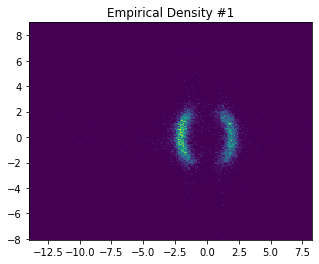

In [69]:
# not stable
plt.hist2d(samples1[:,0], samples1[:,1], cmap='viridis', rasterized=False, bins=200, density=True)
plt.gca().set_aspect('equal', adjustable='box')
# plt.xlim([-3.5, 3.5])
# plt.ylim([-3.5, 3.5])
plt.title('Empirical Density #1')
plt.show()

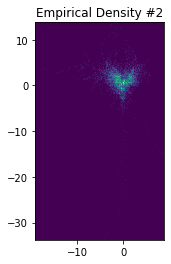

In [74]:
# not stable
plt.hist2d(samples2[:,0], samples2[:,1], cmap='viridis', rasterized=False, bins=200, density=True)
plt.gca().set_aspect('equal', adjustable='box')
# plt.xlim([-3.5, 3.5])
# plt.ylim([-3.5, 3.5])
plt.title('Empirical Density #2')
plt.show()

## Experiemnt on paper

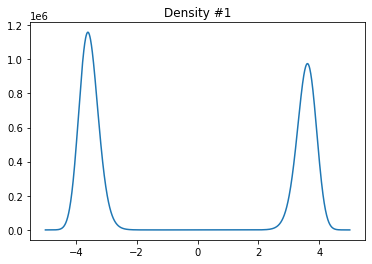

In [43]:
def npdensity3(x):
    assert(type(x) == float or type(x) == np.ndarray)
    u = (x+5) * (x+1) * (x-1.02) * (x-5) / 10 + 0.5
    return np.exp(-u)

x = np.linspace(-5, 5, 1000)

y = npdensity3(x)
plt.plot(x, y)
plt.title('Density #1')
plt.show()

In [44]:
def potential3(x):
    u = (x+5) * (x+1) * (x-1.02) * (x-5) / 10 + 0.5
    return u

def density3(x):
    return torch.exp(-potential3(x))

In [75]:
samples1 = fractional_approx_LMC(potential3, density3, alpha=1.7, steps=0.001, dim=1)
samples2 = fractional_approx_LMC(potential3, density3, alpha=2, steps=0.01, dim=1)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:14: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  


  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

In [46]:
for i in range(0, len(samples1), 100):
    print(samples1[i]) # need to be between -4 and 4

[4.12627328]
[4.01064441]
[3.81822008]
[3.84941806]
[3.83565186]
[3.83658452]
[3.76401728]
[3.78498517]
[3.7208652]
[3.6992501]
[3.62023912]
[3.62524161]
[3.591237]
[3.57061503]
[3.62333241]
[3.62894421]
[3.55225587]
[3.86486407]
[4.33909431]
[4.3090993]
[4.27018382]
[4.30407583]
[4.26042497]
[4.29885407]
[4.13163319]
[4.27296533]
[4.25960042]
[4.20675033]
[4.11922231]
[4.09397075]
[4.09401106]
[4.05635556]
[3.98342802]
[3.96090299]
[3.72635209]
[3.80615587]
[3.71333725]
[3.71942126]
[3.82651151]
[3.8165744]
[3.81834347]
[3.69079721]
[3.75486283]
[3.85643408]
[3.85922986]
[3.75847993]
[3.7022953]
[3.68082577]
[3.64584221]
[3.62254895]


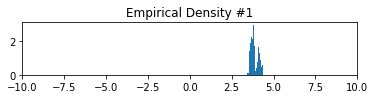

In [47]:
plt.hist(samples1, bins=200, density=True)
plt.gca().set_aspect('equal', adjustable='box')
plt.xlim(-10, 10)
plt.title('Empirical Density #1')
plt.show()

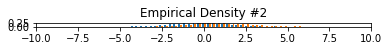

In [48]:
plt.hist(samples2, bins=200, density=True)
plt.gca().set_aspect('equal', adjustable='box')
plt.xlim(-10, 10)
plt.title('Empirical Density #2')
plt.show()